In this example we will compare Solcast API historical data with measurements obtained from [SURFRAD](https://gml.noaa.gov/grad/surfrad/). We will use the [PVLib library](https://pvlib-python.readthedocs.io/en/stable/index.html) to fetch the measurements data from SURFRAD: 

In [ ]:
# ! pip install pvlib pandas matplotlib

fetching 3 days worth of measurements for the Goodwin Creek Mississippi SURFRAD site with PVLib's `read_surfrad`

<Axes: xlabel='period_end[UTC-5]'>

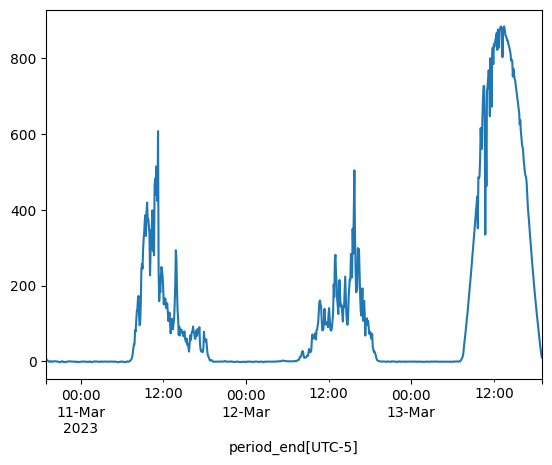

In [2]:
import pandas as pd
from pvlib.iotools import read_surfrad

measurements = []
for d in [0, 1, 2]:
    site = read_surfrad(f'https://gml.noaa.gov/aftp/data/radiation/surfrad/Goodwin_Creek_MS/2023/gwn2307{d}.dat')
    measurements.append(site[0]['ghi'])  

# concatenate the 3 days of data and resample to 60 minutes
measurements = pd.concat(measurements).resample('5Min', closed='right', label='right').mean()
measurements.index = measurements.index.tz_convert("-05:00:00")
measurements.index.name = "period_end[UTC-5]"
measurements.plot()

retrieve the same data from the Solcast API using the SDK's `historic.radiation_and_weather` module:

<Axes: xlabel='period_end[UTC-5]'>

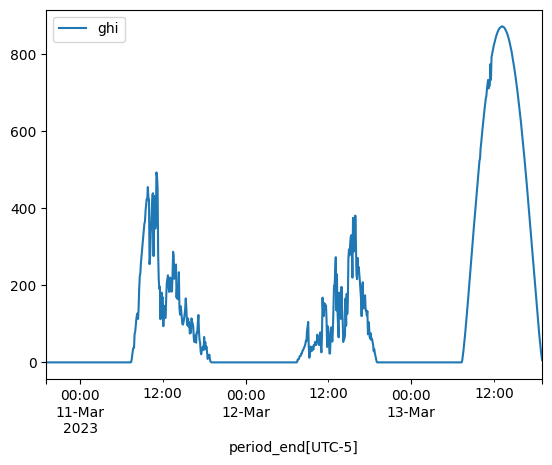

In [3]:
from solcast import historic

# NOTE: this will consume an API request!
solcast = historic.radiation_and_weather(
    latitude=34.2547,
    longitude=-89.8729,
    output_parameters='ghi',
    start=measurements.index.min(),
    end=measurements.index.max(),
    period='PT5M',
    timezone="-5"
)

solcast = solcast.to_pandas()
solcast.index.name = "period_end[UTC-5]"
solcast.plot()

Join the measurements with Solcast's estimated actuals

<Axes: xlabel='period_end[UTC-5]'>

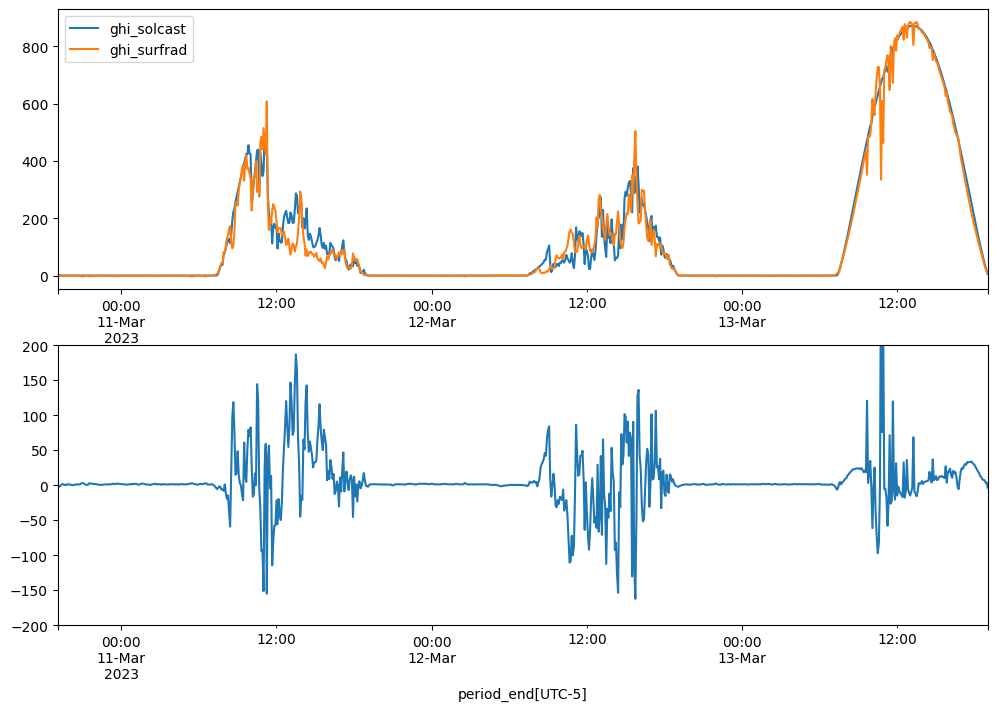

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(12,8))
df = solcast.join(measurements, lsuffix='_solcast', rsuffix='_surfrad')
df.plot(ax=axs[0])

# compute differences
(df['ghi_solcast'] - df['ghi_surfrad']).plot(ax=axs[1], ylim=[-200,200])